<a href="https://colab.research.google.com/github/nigoda/machine_learning/blob/main/22_Transfer_learning_with_TF_hub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This totorial demonstrates:

1. How to use TensorFlow Hub with tf.keras.
2. How to do image classification using TensorFlow Hub.
3. How to do simple transfer learning.

### **Setup**

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt

!pip install tensorflow-gpu

import tensorflow as tf



In [ ]:
!pip install tensorflow_hub
import tensorflow_hub as hub

from tensorflow.keras import layers

## **An ImageNet classifier**

Use hub.module to load a mobilenet, and tf.keras.layers. Lambda to wrap it up as a keras layer. Any Tensorflow 2 compatible image classifier URL from tfhub.dev will work here.

In [ ]:
classifier_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #param {type:"string"}

In [ ]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])



### **Run it on single image**

Download a single image to try the model on.

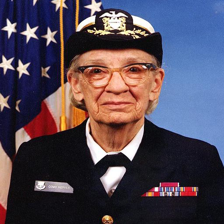

In [ ]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [ ]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

Add a patch dimension, and pass the image to the model.

In [ ]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

The result is a 1001 element vector of logits, rating the probability of each class for the image.

So the top class ID can be found with argmax:

In [ ]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

### **Decode the predictions**
We have the predicted class ID, Fetch the ImageNet Labels, and decode the predictions

In [ ]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

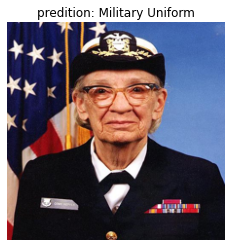

In [ ]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_= plt.title("predition: " + predicted_class_name.title())

### **Simple transfer learning**

Using TF Hub it is simple to retrain the top layer of the model to recognize the classes in our datasets.

**Dataset**

 For this example you wil use the Tendorflow flowers dataset:

In [ ]:
data_root = tf.keras.utils.get_file(
    'flower_photos', 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

The simplest way to load this data into our module is using tf.keras.preprocessing.image.ImageDataGenerator's,
All of TensorFlow Hub's image modules expert float input in the [0, 1]range. Use the ImageDataGenerator's rescale paramenter to achive this.

The image size will be handled later.

In [ ]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


The resulting object is an iterator that returns image_batch, label_batch pairs.

In [ ]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


### **Run the classifier on the image batch.**
Now run the classifier on the image batch.


In [ ]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [ ]:
predicted_class_name = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_name


array(['hen-of-the-woods', 'daisy', 'hip', 'volcano', "jack-o'-lantern",
       'bee', 'daisy', 'cloak', 'daisy', 'cardoon', 'pot', 'gyromitra',
       'daisy', 'coral reef', 'streetcar', 'daisy', 'quill', 'broccoli',
       'daisy', 'hay', 'daisy', 'cardoon', 'daisy', 'cardoon', 'daisy',
       'bee', 'daisy', 'daisy', 'daisy', 'picket fence', 'pot',
       'feather boa'], dtype='<U30')

Now check how these predictions line up with the images:

### **Download the headless model**
TensorFlow Hub also distribute models without the top classification layer. These can be used to easily do transfer learning. Any [Tensorflow 2 compatible image feature vector URL](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub) from tfhub.dev will work here.

In [ ]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"

Create the feature extractor.

In [ ]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

It return a 1280-length vector for each image:

In [ ]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


Freeze the variables in the feature extractor layer, so that the training only modifies the new classifer layer.

In [ ]:
feature_extractor_layer.trainable = False

### **Attach a classification head**
Now wrap the hub layer in a tf.keras.Sequential model, and add a new classification layer.

In [ ]:
model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(image_data.num_classes, activation='softmax')
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
predictions = model(image_batch)

In [ ]:
predictions.shape

TensorShape([32, 5])

### **Train the model**
Use compile to configure the training process:

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['acc']
)

Now use the .fit method to train the model.

To keep this example short train just 2 epochs. To visualize the training progress, use a custom callback to log the loss and accuracy of each batch individually, instead of the epoch average.

In [ ]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [ ]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit(image_data, epochs=2,
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [batch_stats_callback])

Epoch 1/2
115/115 [==============================] - 112s 942ms/step - loss: 0.5280 - acc: 0.7812
Epoch 2/2
115/115 [==============================] - 108s 936ms/step - loss: 0.3770 - acc: 0.8750


Now after, even just a few training iterations, we can already see that the model is making progress on the task.

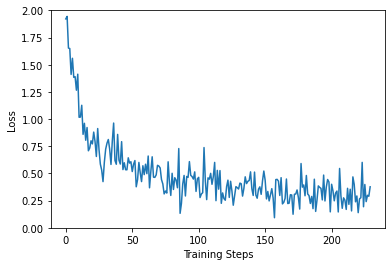

In [ ]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

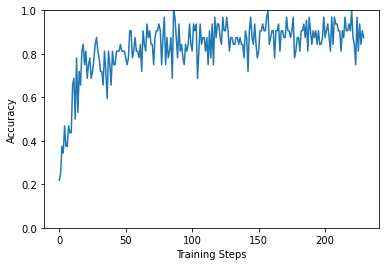

In [ ]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

### **Check the prediction**
to redo the plot from before, first get the ordered list of class names:

In [ ]:
class_names = sorted(image_data.class_indices.items(),
                     key = lambda pair : pair[1])

class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

Run the image batch through the model and convert the indicess to class names.

In [ ]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

Plot the result

In [ ]:
label_id = np.argmax(label_batch, axis=-1)

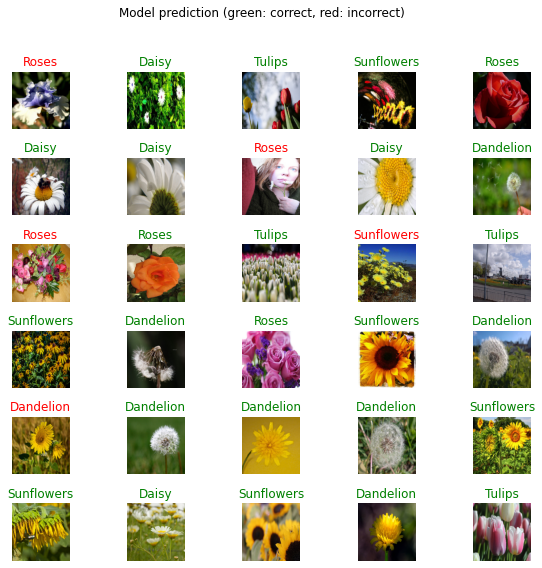

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
  _ = plt.suptitle("Model prediction (green: correct, red: incorrect)")

### **Export your model**
Now that you've trained the model, export it as a savedmodel:

In [ ]:
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path)

export_path

INFO:tensorflow:Assets written to: /tmp/saved_models/1623755340/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1623755340/assets


'/tmp/saved_models/1623755340'

Now confirm that we can reload it, and still gives the same result:

In [ ]:
reloaded = tf.keras.models.load_model(export_path)

In [ ]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [ ]:
abs(reloaded_result_batch - result_batch).max()

0.0

This saved model can loaded for Inference later, or convert to TFLite or TFis.